In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from lsst.afw.image.exposure import ExposureF
from lsst.geom import Box2I, Point2I

import danish
import batoid

from ipywidgets import interact, Dropdown

In [2]:
def getdata(fn, data_bbox, bkg_bbox):
    donut = ExposureF.readFits(fn)
    img = donut[bbox].image.array
    bkg = donut[bkg_bbox].image.array

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
    axes[0].imshow(img, vmin=11000, vmax=40000)
    axes[1].imshow(bkg, vmin=12500, vmax=12800)
    plt.show()
    
    bkg_level = np.median(bkg.ravel())
    bkg_var = np.var(bkg.ravel())
    return img-bkg_level, bkg_var

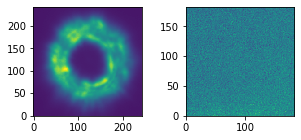

In [3]:
# point = Point2I(2179, 1630)
# bbox = Box2I(point, point)
# bbox = bbox.dilatedBy(121)
# sky_point = Point2I(2179, 1630+275)
# sky_bbox = Box2I(sky_point, sky_point)
# sky_bbox = sky_bbox.dilatedBy(91)
# img, var = getdata(
#     "../tests/data/donut_2021032300307.fits",
#     bbox,
#     sky_bbox
# )
# img_list = [img]
# var_list = [var]

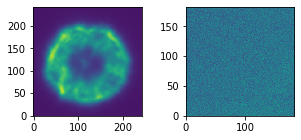

In [4]:
# point = Point2I(2170, 1630)
# bbox = Box2I(point, point)
# bbox = bbox.dilatedBy(121)
# sky_point = Point2I(2170, 1630+275)
# sky_bbox = Box2I(sky_point, sky_point)
# sky_bbox = sky_bbox.dilatedBy(91)
# img, var = getdata(
#     "../tests/data/donut_2021032300308.fits",
#     bbox,
#     sky_bbox
# )
# img_list.append(img)
# var_list.append(var)

In [5]:
# with open("../tests/data/AuxTelTestDonuts.pkl", 'wb') as f:
#     pickle.dump([img_list, var_list], f)

In [3]:
with open("../tests/data/AuxTelTestDonuts.pkl", 'rb') as f:
    img_list, var_list = pickle.load(f)

In [4]:
fiducial_telescope = batoid.Optic.fromYaml("AuxTel.yaml")
intra_telescope = fiducial_telescope.withLocallyShiftedOptic("M2",[0, 0, -0.0008])
extra_telescope = fiducial_telescope.withLocallyShiftedOptic("M2",[0, 0, 0.0008])
wavelength = 677e-9

In [5]:
def fit(img, var, telescope, jmax=11):
    z_ref = batoid.zernikeTA(
        telescope, 0.0, 0.0, wavelength,
        nrad=20, naz=120, reference='chief',
        jmax=jmax, eps=0.2538/0.6
    )
    z_ref *= wavelength
    
    AuxTel_obsc_radii = dict(Baffle_M2c_inner=0.2115)
    AuxTel_obsc_motion = dict(Baffle_M2c_inner=-2.7000030360993734)

    factory = danish.DonutFactory(
        R_outer=0.6, R_inner=0.2115,
        obsc_radii=AuxTel_obsc_radii, 
        obsc_motion=AuxTel_obsc_motion,
        focal_length=21.6, pixel_scale=10e-6
    )

    z_terms = np.arange(4, jmax+1)
    fitter = danish.SingleDonutModel(
        factory, 
        z_ref=z_ref, 
        z_terms=z_terms, 
        thx=0.0, thy=0.0, 
        npix=243
    )    
    
    guess = [0.0, 0.0, 2.0]+[0.0]*(jmax-3)

    result = least_squares(
        fitter.chi, guess, jac=fitter.jac,
        ftol=1e-3, xtol=1e-3, gtol=1e-3,
        max_nfev=20, verbose=2,
        args=(img, var)
    )

    dx_fit, dy_fit, fwhm_fit, *z_fit = result.x
    z_fit = np.array(z_fit)

    model = fitter.model(
        dx_fit, dy_fit, fwhm_fit, z_fit
    )

    z_sum = z_fit + z_ref[4:jmax+1]

    print(f"fwhm    {fwhm_fit:.2f} arcsec")
    for i in range(4, jmax+1):
        out = f"{i:2d}  {z_sum[i-4]/wavelength:9.3f} waves =   "
        out += f"{z_sum[i-4]*1e9:9.3f} nm"
        print(out)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))
    axes[0].imshow(img)
    axes[1].imshow(model)
    axes[2].imshow(img/img.sum()-model/model.sum(), cmap='seismic')
    plt.show()

In [6]:
@interact(
    inex=Dropdown(options=['intra', 'extra'], value='intra', ),
    jmax=Dropdown(options=[4, 6, 10, 11, 15, 21, 22], value=11)
)
def f(inex, jmax):
    if inex == 'intra':
        img = img_list[0]
        var = var_list[0]
        scope = intra_telescope
    else:
        img = img_list[1]
        var = var_list[1]
        scope = extra_telescope
    fit(img, var, scope, jmax)

interactive(children=(Dropdown(description='inex', options=('intra', 'extra'), value='intra'), Dropdown(descri…